# Universidade Federal de Minas Gerais - PPGCC
------------------------------------------
### Trabalho Prático 2: Implementação do algoritmo de Boosting
### Aprendizado de Máquina 2018.1 - Adriano Veloso
### Aluno: Markos Viggiato
-----------------------------------------

## 1 - Introdução

O trabalho prático 2 da disciplina de Aprendizado de Máquina consiste em implementar um algoritmo de boosting para classificação binária de dados com atributos categóricos. Esta técnica de aprendizado consiste em construir um modelo forte a partir de classificadores "fracos", que possuem performance um pouco melhor do que uma escolha aleatória.

Mais especificamente, neste trabalho, foi implementado o AdaBoost. Este algoritmo consiste na execução das seguintes ações:

<ol>
  <li>Todas as instâncias de treinamento recebem o mesmo peso = 1/N, onde N é o tamanho do dataset de treinamento.</li>
  <li>O processo de treinamento é feito nos dados com os pesos já atribuídos e escolhe-se o melhor classificador fraco (e.g., um decision stump), ou seja, escolhe-se o classificador que possuir menor erro de treinamento.</li>
  <li>O classificador escolhido recebe um peso (alfa), que significa a contribuição que este classificador terá no modelo final.</li>
  <li>Atualiza-se os pesos dos dados de treinamento e repete-se os passos 2, 3 e 4 até que haja convergência (por exemplo, erro empírico próximo de zero).</li>
</ol>

### 1.1 - Dados de Entrada

Os dados utilizados neste trabalho referem-se ao tic-tac-toe (jogo da velha). O dataset consiste de 958 configurações possíveis, em que há 9 features de entrada (cada uma correspondente a uma célula no tabuleiro do jogo), com 3 valores possíveis ('x' para o jogador um, 'o' para o jogador dois e 'b' para nenhum) e 2 classificações possíveis (<b>positivo</b> quando o jogador um vence e <b>negativo</b> quando o jogador um perde).

De acordo com as informações descritivas dos dados fornecidas pelo repositório onde encontram-se os dados (UCI Machine Learning Repository), tem-se as seguintes descrições para cada entrada do dataset com seus respectivos valores possíveis:

1. top-left-square: {x,o,b}
2. top-middle-square: {x,o,b}
3. top-right-square: {x,o,b}
4. middle-left-square: {x,o,b}
5. middle-middle-square: {x,o,b}
6. middle-right-square: {x,o,b}
7. bottom-left-square: {x,o,b}
8. bottom-middle-square: {x,o,b}
9. bottom-right-square: {x,o,b}
10. Class: {positive,negative}

A seguir, podemos ver os trechos de código correspondentes aos imports de bilbiotecas úteis e carregamento dos dados de entrada. É importante lembrar que neste trabalho não foi utilizada nenhuma solução pronta (por meio de bibliotecas, por exemplo) para implementar o AdaBoost. Apenas bilbiotecas com funções simples foram utilizadas.

In [61]:
# import of basic libraries for simple calculations and plots
from itertools import product
from matplotlib import pyplot as plt
import numpy as np

In [62]:
# converting to numeric 
xLabels = {'x': 1, 'o': -1, 'b': 0}
yLabels = {'positive': 1, 'negative': -1}
featureDescription = {'top-left-square': 0, 'top-middle-square': 1, 'top-right-square': 2,
                  'middle-left-square': 3, 'middle-middle-square': 4, 'middle-right-square': 5,
                  'bottom-left-square': 6, 'bottom-middle-square': 7, 'bottom-right-square': 8}
number_config = 958
numberFeatures =  9

# initialization
X = np.zeros((number_config, numberFeatures)).astype(np.int)
y = np.zeros((number_config, 1))
i = 0
j=0
test_acc_all = []
test_err_all = []

# input reading
with open('tic-tac-toe.txt', 'r') as dataset:
    for game in dataset:
        gameData = game.strip().split(',')
        for position in gameData:
            if position == 'x':
                X[i,j] = 1
            if position == 'o':
                X[i,j] = -1
            if position == 'b':
                X[i,j] = 0
            if position == 'positive':
                y[i] = 1
            if position == 'negative':
                y[i] = -1
            j += 1
        i += 1
        j=0
        
indices =  np.arange(X.shape[0])
#print(X.shape[0])
new_indices = np.random.choice(indices, 811)

# training and test dataset
X_train_dataset = X[new_indices,]
y_train_dataset = y[new_indices,]
X_test_dataset = np.delete(X, new_indices, 0)
y_test_dataset = np.delete(y, new_indices, 0)
total_folds = [(0, 163), (163, 326), (326, 489), (489, 652), (652, 811)]

### 1.2 - Implementação do agoritmo de Boosting - AdaBoost

Neste trabalho, foram utilizadas arvóres de decisão com apenas um atributo como <i>decision stumps</i>, visto que tais árvores são simples para entender e são classificadores fracos. No dataset, tem-se 9 features, cada uma com 3 possíveis valores ('x', 'o' ou 'b') e 2 classes possíveis (positivo ou negativo), portanto, foram utilizados um total de 9*3*2 = 54 stumps. Cada stump é representado por um vetor de 3 posições: a primeira posição corresponde à feature que está sendo utilizada para a decisão (top-left-square, top-middle-square, etc); a segunda posição corresponde ao valor da feature ('x', 'o' ou 'b'); por fim, a terceira posição corresponde à classificação segundo o stump (positivo ou negativo). A seguir, pode-se ver alguns exemplos dos stumps utilizados:

<ul>
  <li> (top-left-square, x, positive) </li>
  <li> (middle-left-square, o, negative) </li>
</ul>

No caso do primeiro stump apresentado, por exemplo, tem-se que a célula mais acima à esquerda foi preenchida com o valor do jogador um 'x' e o stump classifica como positivo, ou seja, o jogador um é o vencedor segundo este stump.

O processo de treinamento ocorre a partir da avaliação de todos os 54 stumps nos dados de treino com pesos iniciais iguais (1/N). Escolhe-se o stump que apresentar menor erro empírico, ou seja, que classificar mais instâncias de treinamento corretamente. Feito isso, computa-se o erro simples ponderado pelos pesos e o coeficiente alfa, que indica a importância daquele classificador no modelo final. Tal coeficiente é computado de acordo com a seguinte fórmula:


<img src="http://labsoft.dcc.ufmg.br/lib/exe/fetch.php?cache=&media=people:students:alpha.png" alt="Alpha image">

onde o <i>epsilon</i> representa o erro ponderado pelos pesos na iteração t. Após calcular este coeficiente, deve-se atualizar os pesos dos dados de treinamento. Tal atualização é feita de forma que os dados classificador erroneamente tem seus pesos aumentados, para que o próximo classificador foque em classificá-los corretamente. A seguir, pode-se ver a fórmula utilizada aqui para atualizar os pesos. Note que a variávle z corresponde a um fator de normalização para que os pesos somem 1, h(X) é a predição do modelo e y(X) é a classificação correta.

<img src="http://labsoft.dcc.ufmg.br/lib/exe/fetch.php?cache=&media=people:students:weights.png" alt="Weights image">

O modelo final (forte) é obtido por meio da soma de cada classificador fraco ponderado por seu coeficiente. Neste trabalho, utiliza-se a soma pois o AdaBoost é aditivo. Por exemplo, na imagem a seguir pode-se ver como seria obtido o modelo final a partir de 3 classificadores fracos, utilizando a função sinal.

<img src="http://labsoft.dcc.ufmg.br/lib/exe/fetch.php?cache=&media=people:students:model.png" alt="Model image">


## 2 - Experimentos e Resultados

A seguir, são apresentados os experimentados executados, juntamento com o código, e respectivas discussões. Neste trabalho, o método de avaliação utilizado foi o cross-validation com 5 folds. Assim, os dados foram divididos em 5 folds e, a cada iteração, quatro folds foram utilizados para treinar o modelo enquanto um fold foi utilizado para avaliar o modelo. Este procedimento foi repetido 5 vezes (5-fold cross-validation).

Foram definidas algumas funções para deixar o código mais modularizado. A seguir, podemos ver a função best_stump para encontrar o melhor stump possível, isto é, aquele que possui menor erro de treinamento. Podemos ver também a função de classificação, que é utilizada para obter a classificação de um determinado stump passado como argumento.

In [63]:
def best_stump(X, y, weights, allStumps):
    maxCorrect = np.finfo('float').min
    selected_feature = -1
    selected_category = -2
    selected_classification = 0
    index_correct_classification=0
    weightedClassification=0
    for candidateStump in allStumps:
        feature = candidateStump[0]
        category = candidateStump[1]
        cclass = candidateStump[2]
        #while index_correct_classification < X.shape[0]:
        #if (X[index_correct_classification, feature] == category) & (y[index_correct_classification,0] == cclass):
        #            weightedClassification += weights[index_correct_classification]
                #index_correct_classification += 1
        weightedClassification = np.sum(weights[(X[:, feature] == category) & (y[:, 0] == cclass)])
        if weightedClassification > maxCorrect:
            maxCorrect = weightedClassification
            selected_feature = feature
            selected_category = category
            selected_classification = cclass
    return maxCorrect, selected_feature, selected_category, selected_classification

def classify(X, stump):
    n = X.shape[0]
    stump_predictions = np.zeros((n, 1))
    stump_feature = stump[0]
    stump_category = stump[1]
    stump_classification = stump[2]
    for i in range(n):
        if X[i, stump_feature] == stump_category:
            stump_predictions[i] = stump_classification
        else:
            stump_predictions[i] = -stump_classification
    return stump_predictions

### 2.1 - Execução principal

A execução principal do algoritmo consiste em 5 iterações, uma para cada fold do cross-validation. Para cada iteração, tem-se um conjunto de treino (4 folds) diferente do cnjunto de teste (1 fold). O segundo loop consiste em iterar em todos os possíveis stumps gerados, que são 54 no total (9*3*2). Enquanto há stumps para serem avaliados, obtém-se o melhor stump desse conjunto (menor erro de treinamento) e utiliza-o para classificar os dados, obtendo-se os erros e acertos na classificação (quer serão plotados mais adiante). Feito isso, calcula-se o erro e o coeficiente alfa e atualiza-se os pesos dos dados de treino. Esse procedimento é realizado até que não reste nenhum stump para ser avaliado. O modelo final vai sendo contruído durante esse processo, utilizando uma soma de cada stump ponderado por seu coeficiente alfa.

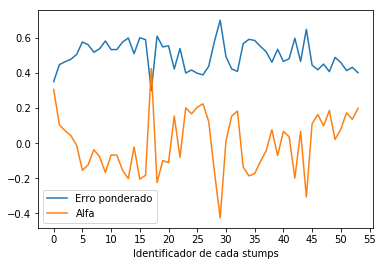

In [64]:
for fold in total_folds:
    stumpIndex = 0
    
    # shuffle data
    indices =  np.arange(X_train_dataset.shape[0])
    np.random.shuffle(indices)
    X, y = X_train_dataset[indices], y_train_dataset[indices]
    xTrain, xTest, yTrain, yTest = split_data(fold, X, y)
    n = xTrain.shape[0]
    stumps = []
    weighted_err = []
    test_err = []
    test_acc = []
    alphas = []
    
    # initial weights: 1/n
    weights = np.full((n, 1), 1 / n)
    
    # 54 possible stumps: 9 features * 3 values * 2 classes
    allStumps = list(product(featureDescription.values(), xLabels.values(), yLabels.values()))
    
    while allStumps:
        max_correct, selected_feature, selected_category, selected_classification = best_stump(xTrain, yTrain, weights, allStumps)
        stumps.append((selected_feature, selected_category, selected_classification))

        # classify using the stump and check how many classifications are correct
        stumpPrediction = classify(xTrain, stumps[-1])

        # multiplication: if prediction is corret [(1*1 or -1*(-1))] = 1; otherwise, [1*(-1) or -1*1] = -1
        predictionErrors = np.multiply(yTrain, stumpPrediction)    
        weightedError = np.sum(np.multiply(weights, (predictionErrors == -1).astype(np.int)))
        weighted_err.append(weightedError)

        # compute alpha coefficient
        alpha_coefficient = (0.5 * np.log((1 - weightedError) / weightedError))
        alphas.append(alpha_coefficient)

        # update weights according to the formula given in class
        updated_weights = np.multiply(weights, np.exp(((-1) * predictionErrors) * alphas[-1]))
        normalized_weights = updated_weights / np.sum(updated_weights)

        # remove the evaluated stump
        allStumps.remove(stumps[-1])
        
        # building the final strong model
        predictions = np.zeros((xTest.shape[0], 1))   
        for coeficient, stump in zip(alphas, stumps):
            predictions = predictions + coeficient * classify(xTest, stump)
        all_prediction = np.multiply(yTest, np.sign(predictions))
        
        # 54 errors and accuracies - one for each stump
        test_err.append(all_prediction[all_prediction == -1].shape[0] / (1. * xTest.shape[0]))
        test_acc.append(all_prediction[all_prediction == 1].shape[0] / (1. * xTest.shape[0]))
        stumpIndex += 1
        
    test_err_all.append(test_err)
    test_acc_all.append(test_acc)
    
# plot alpha and weighted error
line_up, = plt.plot(weighted_err, label='Erro ponderado')
line_down, = plt.plot(alphas, label='Alfa')
plt.legend(handles=[line_up, line_down])
plt.xlabel('Identificador de cada stumps')
plt.xticks(np.arange(0, 56, 5))
plt.show()
    


No gráfico acima, pode-se observar como os valores do coeficiente alfa e os erros ponderados variam com o stump que é selecionado. Como esperado, alguns stumps contribuem mais (alfa maior) para o modelo forte no final. Pode-se ver que quando o erro ponderado é menor, ou seja o stump possui acurácia melhor, o coeficiente é maior, demosntrando que os stumps que apresentam erros menores serão mais importantes no modelo final (por exemplo, o stump 17 na figura acima). Da mesma forma, se o stump apresentar um erro maior, sua contribuição, e portanto o valor do coeficiente alfa, tende a ser menor para o modelo final (por exemplo, o stump identificado por 29 na figura acima).

### 2.2 - Gráficos de erro no treinamento (cross-validation)

A seguir, podemos ver como o algoritmo se comportou com relação ao erro durante o procedimento de cross-validation com o aumento no número de stumps utilizados.

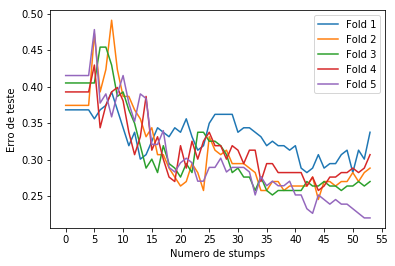

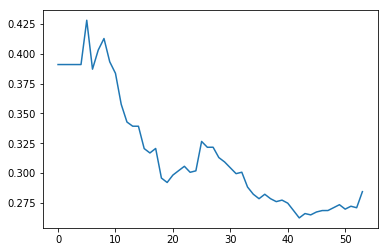

In [65]:
# plot test error for each fold
error = np.array(test_err_all)
handles = []
for i in range(error.shape[0]): 
    line, = plt.plot(error[i], label='Fold %d' % (i+1))
    handles.append(line)
plt.legend(handles=handles)
plt.ylabel('Erro de teste')
plt.xlabel('Numero de stumps')
plt.xticks(np.arange(0, 56, 5))
plt.show()

# plot average test error for all 5 folds per number of stumps
test_err_all_mean = np.zeros((54, 1))
for i in range(0,54):
    test_err_all_mean[i] = (np.sum([test_err_all[0][i],test_err_all[1][i],test_err_all[2][i],test_err_all[3][i],test_err_all[4][i]])) / 5
plt.plot(test_err_all_mean)

Nos gráficos acima, podemos observar como o erro decresce com o aumento no número de stumps, ou seja, de fato ao se construir um modelo a partir de modelos fracos, é possível obter um classificador forte.

No primeiro gráfico, pode-se ver que o comportamento do erro é similar para todos os 5 folds utilizados, com pequenas variações. O segundo gráfico corresponde à média dos valores dos 5 folds, com a finalidade de mostrar de maneira mais clara o comportamento do erro de diminuir com o aumento no número de stumps.

### 2.3 - Avaliação do modelo no dataset de teste

In [67]:
# average accuracy and error for cross-validation (training)
#print ("Acurácia de teste média para o cross-validation (%):", np.sum(np.array(test_acc_all)[:, -1]) / 5)
print ("Erro de teste médio para o cross-validation (treinamento):", np.sum(np.array(test_err_all)[:, -1]) / 5)

# average erro for test dataset
correct_prediction = 0
for i in range(len(X_test_dataset)):
    model_prediction = 0
    for coefficient, stump in zip(alphas, stumps):
        feature = stump[0]
        feature_value = stump[1]
        model_pred = stump[2]
        dataset_value = X_test_dataset[i][feature]
        if dataset_value == feature_value:
            prediction = model_pred
        else:
            prediction = -model_pred
        model_prediction += coefficient * prediction

    # final model prediction
    model_prediction = np.sign(model_prediction)  
    if model_prediction == y_test_dataset[i][0]:
        correct_prediction += 1
    
accuracy = (correct_prediction / len(X_test_dataset))
error = 1 - accuracy
print("Erro médio usando o dataset de teste:", error)

Erro de teste médio para o cross-validation (treinamento): 0.28451595477871666
Erro médio usando o dataset de teste: 0.2736572890025576


No trecho de código acima e nas saídas, podemos observar os valores médios de erro obtidos para o treinamento e teste. O primeiro valor (0.284) refere-se à média dos 5 erros obtidos durante o treinamento usando o método de cross-validation, isto é, a média dos erros obtidos para cada um dos 5 folds. O segundo valor (0.273) corresponde ao erro obtido pelo modelo no dataset de teste apenas. Neste caso, esses dados não foram utilizando durante o treinamento do modelo. Pode-se observar que os valores finais médios são relativamente baixos e, como deveria ser, o método cross-validation fornece uma boa aproximação do erro de teste, visto que ambos os valores apresentados acima (0.284 e 0.273) são próximos.

## 3 - Conclusão

Neste trabalho, foi implementado o algoritmo AdaBoost, que corresponde a uma abordagem específica para algortimos de aprendizado de boosting. Utilizou-se o dataset tic-tac-toe para realizar a classificação binária a partir de atributos categóricos. O método de avaliação cross-validation com 5 folds foi utilizado para avaliar o modelo durante o treinamento e obter uma estimativa do erro esperado. Observou-se que, com o aumento no númeor de stumps (de 1 até 54), o erro médio diminui, como esperado. O modelo final (forte) foi avaliado em um conjunto de dados separado (test dataset) que corresponde a 15% dos dados de entrada iniciais. Como reportado neste relatório, o modelo obtido a partir dos modelos fracos (decision tree stumps) se mostrou eficiente para a tarefa de classificação, apresentando um erro médio de aproximadamente 27%.